In [107]:
# -*- coding: utf-8 -*-

import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.close('all')
import hatyan
import kenmerkendewaarden as kw # pip install git+https://github.com/Deltares-research/kenmerkendewaarden

# set logging level to INFO to get log messages
import logging
logging.basicConfig() # calling basicConfig is essential to set logging level for sub-modules
logging.getLogger("kenmerkendewaarden").setLevel(level="INFO")

# TODO: HW/LW numbers not always increasing (at havengetallen): ['HANSWT','BROUWHVSGT08','PETTZD','DORDT']

tstart_dt = pd.Timestamp(2011,1,1, tz="UTC+01:00")
tstop_dt = pd.Timestamp(2021,1,1, tz="UTC+01:00")
if ((tstop_dt.year-tstart_dt.year)==10) & (tstop_dt.month==tstop_dt.day==tstart_dt.month==tstart_dt.day==1):
    year_slotgem = tstop_dt.year
else:
    year_slotgem = 'invalid'
print(f'year_slotgem: {year_slotgem}')

# dir_base = r'p:\11208031-010-kenmerkende-waarden-k\work'
dir_base = r'p:\11210325-005-kenmerkende-waarden\work'
dir_meas = os.path.join(dir_base,'measurements_wl_18700101_20240101')
# TODO: move to full data folder (otherwise overschrijding and slotgemiddelde is completely wrong)
# dir_meas = os.path.join(dir_base,'measurements_wl_20101201_20220201')

dir_indicators = os.path.join(dir_base,f'out_tidalindicators_{year_slotgem}')
dir_slotgem = os.path.join(dir_base,f'out_slotgem_{year_slotgem}')
dir_havget = os.path.join(dir_base,f'out_havengetallen_{year_slotgem}')
dir_gemgetij = os.path.join(dir_base,f'out_gemgetij_{year_slotgem}')
dir_overschrijding = os.path.join(dir_base,f'out_overschrijding_{year_slotgem}')
os.makedirs(dir_indicators, exist_ok=True)
os.makedirs(dir_slotgem, exist_ok=True)
os.makedirs(dir_havget, exist_ok=True)
os.makedirs(dir_gemgetij, exist_ok=True)
os.makedirs(dir_overschrijding, exist_ok=True)

fig_alltimes_ext = [dt.datetime.strptime(x,'%Y%m%d') for x in os.path.basename(dir_meas).split('_')[2:4]]

# all stations from TK (dataTKdia)
station_list = ['A12','AWGPFM','BAALHK','BATH','BERGSDSWT','BROUWHVSGT02','BROUWHVSGT08','GATVBSLE','BRESKVHVN','CADZD',
                'D15','DELFZL','DENHDR','EEMSHVN','EURPFM','F16','F3PFM','HARVT10','HANSWT','HARLGN','HOEKVHLD','HOLWD','HUIBGT',
                'IJMDBTHVN','IJMDSMPL','J6','K13APFM','K14PFM','KATSBTN','KORNWDZBTN','KRAMMSZWT','L9PFM','LAUWOG','LICHTELGRE',
                'MARLGT','NES','NIEUWSTZL','NORTHCMRT','DENOVBTN','OOSTSDE04','OOSTSDE11','OOSTSDE14','OUDSD','OVLVHWT','Q1',
                'ROOMPBNN','ROOMPBTN','SCHAARVDND','SCHEVNGN','SCHIERMNOG','SINTANLHVSGR','STAVNSE','STELLDBTN','TERNZN','TERSLNZE','TEXNZE',
                'VLAKTVDRN','VLIELHVN','VLISSGN','WALSODN','WESTKPLE','WESTTSLG','WIERMGDN','YERSKE']
station_list = ["VLISSGN","HOEKVHLD","IJMDBTHVN","HARLGN","DENHDR","DELFZL","SCHIERMNOG","VLIELHVN","STELLDBTN","SCHEVNGN","ROOMPBTN"] # subset of 11 stations along the coast
# TODO: maybe add from Dillingh 2013: DORDT, MAASMSMPL, PETTZD, ROTTDM
station_list = ["VLISSGN","HOEKVHLD","HARLGN","DENHDR","DELFZL","SCHIERMNOG","VLIELHVN","SCHEVNGN","ROOMPBTN"] 
station_list = ["VLISSGN"]

nap_correction = False

compute_indicators = False
compute_slotgem = False
compute_havengetallen = False
compute_gemgetij = False
compute_overschrijding = True


for current_station in station_list:
    print(f'starting process for {current_station}')
    plt.close('all')
    
    # timeseries are used for slotgemiddelden, gemgetijkrommen (needs slotgem+havget)
    data_pd_meas_all = kw.read_measurements(dir_output=dir_meas, station=current_station, extremes=False, nap_correction=nap_correction)
    if data_pd_meas_all is not None:
        #crop measurement data
        data_pd_meas_10y = hatyan.crop_timeseries(data_pd_meas_all, times=slice(tstart_dt,tstop_dt-dt.timedelta(minutes=10)))#,onlyfull=False)
    
    # extremes are used for slotgemiddelden, havengetallen, overschrijding
    data_pd_HWLW_all = kw.read_measurements(dir_output=dir_meas, station=current_station, extremes=True, nap_correction=nap_correction)
    if data_pd_HWLW_all is not None:
        # TODO: make calc_HWLW12345to12() faster: https://github.com/Deltares/hatyan/issues/311
        data_pd_HWLW_all_12 = hatyan.calc_HWLW12345to12(data_pd_HWLW_all) #convert 12345 to 12 by taking minimum of 345 as 2 (laagste laagwater)
        #crop timeseries to 10y
        data_pd_HWLW_10y_12 = hatyan.crop_timeseries(data_pd_HWLW_all_12, times=slice(tstart_dt,tstop_dt),onlyfull=False)
    
    
    
    

year_slotgem: 2021


INFO:kenmerkendewaarden.data_retrieve:loading VLISSGN_measwl.nc


starting process for VLISSGN


INFO:kenmerkendewaarden.data_retrieve:loading VLISSGN_measext.nc


In [109]:
    ###OVERSCHRIJDINGSFREQUENTIES
    # TODO: SLR trend correctie voor overschrijdingsfrequenties en evt ook voor andere KW?
    # TODO: resulting freqs seem to be shifted w.r.t. getijtafelboekje (mail PH 9-3-2022)
    # plots beoordelen: rode lijn moet ongeveer verlengde zijn van groene, als die ineens omhoog piekt komt dat door hele extreme waardes die je dan vermoedelijk ook al ziet in je groene lijn
    
    Tfreqs_interested = [5, 2, 1, 1/2, 1/5, 1/10, 1/20, 1/50, 1/100, 1/200,
                         1/500, 1/1000, 1/2000, 1/4000, 1/5000, 1/10000]
    
    if compute_overschrijding and data_pd_HWLW_all is not None:
        print(f'overschrijdingsfrequenties for {current_station}')
        
        # only include data up to year_slotgem
        data_pd_measext = data_pd_HWLW_all_12.loc[:tstop_dt]
        
        #get Hydra-NL and KWK-RMM validation data (only for HOEKVHLD)
        dist_vali_exc = {}
        dist_vali_dec = {}
        if current_station =='HOEKVHLD':
            dir_vali_overschr = os.path.join(dir_base,'data_overschrijding') # TODO: this data is not reproducible yet
            stat_name = 'Hoek_van_Holland'
            dist_vali_exc = {}
            dist_vali_exc['Hydra-NL'] = pd.read_csv(os.path.join(dir_vali_overschr,'Processed_HydraNL','Without_model_uncertainty',f'{stat_name}.csv'), sep=';', header=[0])
            dist_vali_exc['Hydra-NL']['values'] /= 100 # cm to m
            dist_vali_exc['Hydra-NL met modelonzekerheid'] = pd.read_csv(os.path.join(dir_vali_overschr,'Processed_HydraNL','With_model_uncertainty',f'{stat_name}_with_model_uncertainty.csv'), sep=';', header=[0])
            dist_vali_exc['Hydra-NL met modelonzekerheid']['values'] /= 100 # cm to m
            file_vali_exeed = os.path.join(dir_vali_overschr,'Tables','Exceedance_lines',f'Exceedance_lines_{stat_name}.csv')
            if os.path.exists(file_vali_exeed):
                dist_vali_exc['validation'] = pd.read_csv(file_vali_exeed,sep=';')
                dist_vali_exc['validation']['values'] /= 100
            file_vali_dec = os.path.join(dir_vali_overschr,'Tables','Deceedance_lines',f'Deceedance_lines_{stat_name}.csv')
            if os.path.exists(file_vali_dec):
                dist_vali_dec['validation'] = pd.read_csv(file_vali_dec,sep=';')
                dist_vali_dec['validation']['values'] /= 100

overschrijdingsfrequenties for VLISSGN


In [111]:
    ###OVERSCHRIJDINGSFREQUENTIES
    # TODO: SLR trend correctie voor overschrijdingsfrequenties en evt ook voor andere KW?
    # TODO: resulting freqs seem to be shifted w.r.t. getijtafelboekje (mail PH 9-3-2022)
    # plots beoordelen: rode lijn moet ongeveer verlengde zijn van groene, als die ineens omhoog piekt komt dat door hele extreme waardes die je dan vermoedelijk ook al ziet in je groene lijn
    
    Tfreqs_interested = [5, 2, 1, 1/2, 1/5, 1/10, 1/20, 1/50, 1/100, 1/200,
                         1/500, 1/1000, 1/2000, 1/4000, 1/5000, 1/10000]
    
    if compute_overschrijding and data_pd_HWLW_all is not None:
        print(f'overschrijdingsfrequenties for {current_station}')
        
        # only include data up to year_slotgem
        data_pd_measext = data_pd_HWLW_all_12.loc[:tstop_dt]
        
        #get Hydra-NL and KWK-RMM validation data (only for HOEKVHLD)
        dist_vali_exc = {}
        dist_vali_dec = {}
        dir_vali_overschr = os.path.join(dir_base,'data_overschrijding') # TODO: this data is not reproducible yet

        if current_station =='HOEKVHLD':
            stat_name = 'Hoek_van_Holland'

            def set_table(dict, key, path):
                if os.path.exists(path):
                    dict[key] =pd.read_csv(path, sep=';')
                    dict[key]['values'] /= 100 
                return  

            hydra_nl_nouncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','Without_model_uncertainty',f'{stat_name}.csv')
            hydra_nl_uncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','With_model_uncertainty',f'{stat_name}_with_model_uncertainty.csv')
            file_validation_exeedance = os.path.join(dir_vali_overschr,'Tables','Exceedance_lines',f'Exceedance_lines_{stat_name}.csv')
            file_validation_deceedance = os.path.join(dir_vali_overschr,'Tables','Deceedance_lines',f'Deceedance_lines_{stat_name}.csv')

            set_table(dist_vali_exc, 'Hydra-NL', hydra_nl_nouncertainty)
            set_table(dist_vali_exc,'Hydra-NL met modelonzekerheid', hydra_nl_uncertainty)
            set_table(dist_vali_exc, 'validation', file_validation_exeedance)
            set_table(dist_vali_dec,'validation', file_validation_deceedance)

overschrijdingsfrequenties for VLISSGN


In [118]:
path = r'P:\11210325-005-kenmerkende-waarden\work\data_overschrijding\Processed_HydraNL\With_model_uncertainty\VLISSGN.csv'


 
df_hydra_nl =pd.read_csv(path, sep=';', header=[0])

In [119]:
    ###OVERSCHRIJDINGSFREQUENTIES
    # TODO: SLR trend correctie voor overschrijdingsfrequenties en evt ook voor andere KW?
    # TODO: resulting freqs seem to be shifted w.r.t. getijtafelboekje (mail PH 9-3-2022)
    # plots beoordelen: rode lijn moet ongeveer verlengde zijn van groene, als die ineens omhoog piekt komt dat door hele extreme waardes die je dan vermoedelijk ook al ziet in je groene lijn
    
    Tfreqs_interested = [5, 2, 1, 1/2, 1/5, 1/10, 1/20, 1/50, 1/100, 1/200,
                         1/500, 1/1000, 1/2000, 1/4000, 1/5000, 1/10000]
    
    if compute_overschrijding and data_pd_HWLW_all is not None:
        print(f'overschrijdingsfrequenties for {current_station}')
        
        # only include data up to year_slotgem
        data_pd_measext = data_pd_HWLW_all_12.loc[:tstop_dt]
        
        #get Hydra-NL and KWK-RMM validation data (only for HOEKVHLD)
        dist_vali_exc = {}
        dist_vali_dec = {}
        dir_vali_overschr = os.path.join(dir_base,'data_overschrijding') # TODO: this data is not reproducible yet

        stat_name = current_station

        def set_hydra_nl_table(dict, key, path):
            if os.path.exists(path):
                df_hydra_nl =pd.read_csv(path, sep=';', header=[0])
                df_hydra_nl = df_hydra_nl.loc[:, ['Terugkeertijd [jaar]', 'Belastingniveau [m+NAP]/Golfparameter [m]/[s]/Sterkte bekleding [-]']]
                df_hydra_nl['values_Tfreq'] = 1/ df_hydra_nl['Terugkeertijd [jaar]'].str.replace(',', '.').astype(float) 
                df_hydra_nl['values'] = df_hydra_nl['Belastingniveau [m+NAP]/Golfparameter [m]/[s]/Sterkte bekleding [-]'].str.replace(',', '.').astype(float) 
                df_hydra_nl = df_hydra_nl.loc[:, ['values_Tfreq','values']]
                dict[key] = df_hydra_nl
            return  dict  

        def set_table(dict, key, path):
            if os.path.exists(path):
                dict[key] =pd.read_csv(path, sep=';')
                dict[key]['values'] /= 100 
            return  
        
        hydra_nl_nouncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','Without_model_uncertainty',f'{stat_name}.csv')
        hydra_nl_uncertainty = os.path.join(dir_vali_overschr,'Processed_HydraNL','With_model_uncertainty',f'{stat_name}.csv')
        file_validation_exeedance = os.path.join(dir_vali_overschr,'Tables','Exceedance_lines',f'Exceedance_lines_{stat_name}.csv')
        file_validation_deceedance = os.path.join(dir_vali_overschr,'Tables','Deceedance_lines',f'Deceedance_lines_{stat_name}.csv')

        set_hydra_nl_table(dist_vali_exc, 'Hydra-NL', hydra_nl_nouncertainty)
        set_hydra_nl_table(dist_vali_exc,'Hydra-NL met modelonzekerheid', hydra_nl_uncertainty)
        set_table(dist_vali_exc, 'validation', file_validation_exeedance)
        set_table(dist_vali_dec,'validation', file_validation_deceedance)
        
            

overschrijdingsfrequenties for VLISSGN


INFO:kenmerkendewaarden.data_retrieve:no physical_break defined for VLISSGN, returning input timeseries


INFO:kenmerkendewaarden.overschrijding:Calculate unfiltered distribution (inverse=False)
INFO:kenmerkendewaarden.overschrijding:Calculate filtered distribution with trendanalysis
INFO:kenmerkendewaarden.overschrijding:Fit Weibull to filtered distribution with trendanalysis
D:\Proyectos2024\Kenmerkendewaarden\Repository\kenmerkendewaarden\kenmerkendewaarden\overschrijding.py:263: RuntimeWarning: invalid value encountered in scalar power
  return -p_val_gt_threshold * (alpha * x**(alpha - 1)) * (sigma**(-alpha)) * np.exp(-((x/sigma)**alpha) + ((threshold/sigma)**alpha))
INFO:kenmerkendewaarden.overschrijding:Blend trend, weibull and Hydra-NL
INFO:kenmerkendewaarden.data_retrieve:no physical_break defined for VLISSGN, returning input timeseries
INFO:kenmerkendewaarden.overschrijding:Calculate unfiltered distribution (inverse=True)
INFO:kenmerkendewaarden.overschrijding:Calculate filtered distribution with trendanalysis
INFO:kenmerkendewaarden.overschrijding:Fit Weibull to filtered distrib

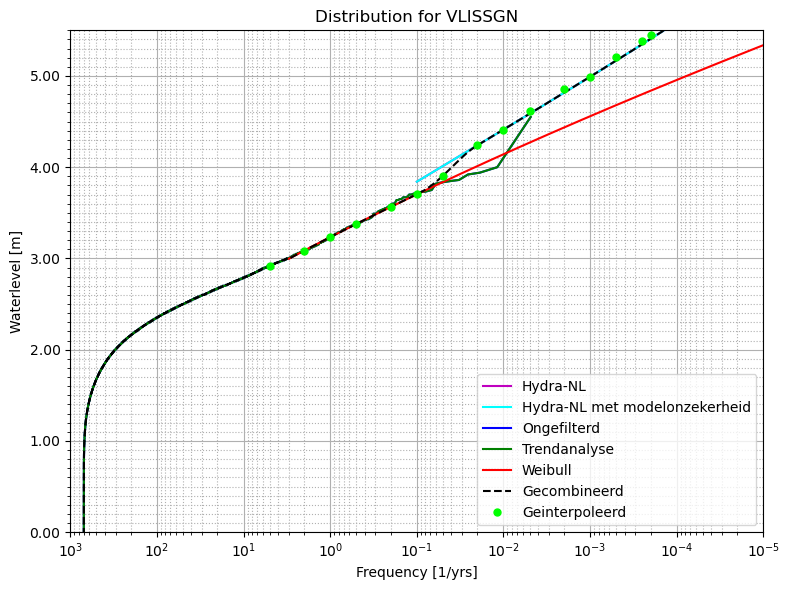

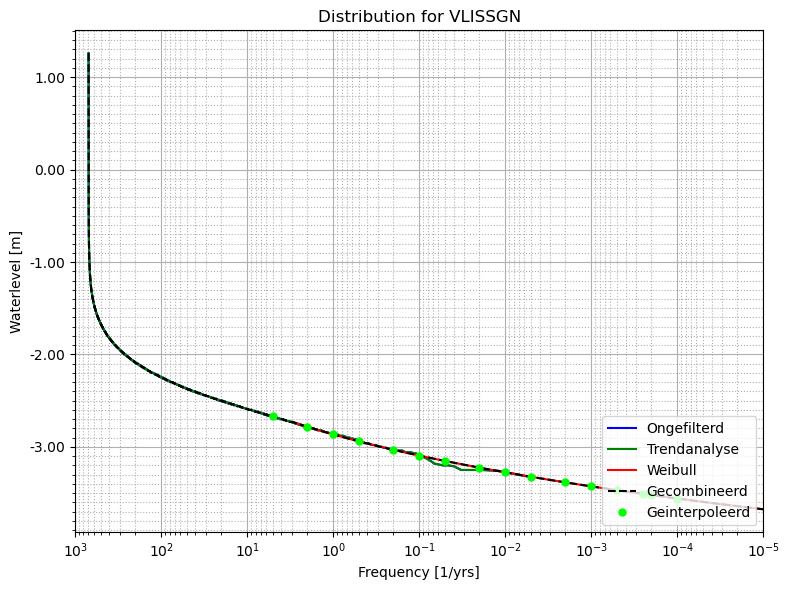

In [120]:

        # 1. Exceedance
        dist_exc = kw.calc_overschrijding(df_ext=data_pd_measext, rule_type=None, rule_value=None, 
                                          clip_physical_break=True, dist=dist_vali_exc,
                                          interp_freqs=Tfreqs_interested)
        df_interp = dist_exc['Geinterpoleerd']
        df_interp.to_csv(os.path.join(dir_overschrijding, f'Exceedance_{current_station}.csv'), index=False, sep=';')
        
        fig, ax = kw.plot_overschrijding(dist_exc)
        ax.set_ylim(0,5.5)
        fig.savefig(os.path.join(dir_overschrijding, f'Exceedance_lines_{current_station}.png'))
        
        # 2. Deceedance
        dist_dec = kw.calc_overschrijding(df_ext=data_pd_measext, rule_type=None, rule_value=None, 
                                          clip_physical_break=True, dist=dist_vali_dec, inverse=True,
                                          interp_freqs=Tfreqs_interested)
        df_interp = dist_dec['Geinterpoleerd']
        df_interp.to_csv(os.path.join(dir_overschrijding, f'Deceedance_{current_station}.csv'), index=False, sep=';')
        
        fig, ax = kw.plot_overschrijding(dist_dec)
        fig.savefig(os.path.join(dir_overschrijding, f'Deceedance_lines_{current_station}.png'))